In [1]:
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

import math

import matplotlib.pyplot as plt

from scipy.spatial import distance

mbyte = 1048576
norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')

In [2]:
%store -r Datasets
data = Datasets['SIFT-10K']
train = data['train']
test = data['test']
n_train = data['n_train']
n_test = data['n_test']
print(data.keys())

dict_keys(['title', 'train', 'test', 'K', 'n_train', 'n_test', 'k_near_neighbors', 'nearest_neighbor'])


# p-stable

In [22]:
from scipy.stats import norm
from scipy.stats import cauchy
import scipy.stats as stats

In [291]:
class Param(object):
    """
    Desc:
        E2LSH param class.
    
    Construct step:
        1. set_r1: 
            set r1 value automatic.
            
        2. draw_W: 
            According to the given value c draw the p1-p2-rho-w figure.
            
        3. set_wkL:
            Give failure probability delta and caculate the value k, L
            
        4. generate_auxiliary_vector:
            Generate G = (g1, g2, ..., gL) -> gi = (h1, h2, ..., hk)
    
    Params:
        class contains follow params.
        self.P
        self.n_
        self.d_
        self.w_
        self.k_
        self.L_
        self.G_
    """

    def __init__(self, P):
        """
        Args:
            P: 数据集
            norm: 正则项(l1, l2)
        """
        self.P = P
        self.n = P.shape[0]
        self.d = P.shape[1]

    def _logab(self, a, b):
        """
        Desc:
            求解 log_a(b)
        """
        return np.log(b) / np.log(a)

    def _probability(self, w, c):
        """
        Args:
            w: 段长
            c: r1, r2, 距离
        """
        a = 2 * norm.cdf(-w/c)
        b = 2 / (np.sqrt(2 * np.pi) * w / c)
        d = np.e ** (-((w**2) / (2 * (c ** 2))))    
        return 1 - a - b * (1 - d)
    
    def _rho(self, p1, p2):
        return (np.log(1/p1) / np.log(1/p2))

    # 1. set r1
    def set_r1(self, r1=None, n_near_neighbors=None):
        """
        Desc:
            获取数据集 r1
        """
        P = self.P
        n = self.n
        d = self.d
        print('Estimate r1')
        print('P: {}'.format(P.shape))

        if r1 is not None:
            self.r1 = r1
            print('set r1 = {}'.format(r1))
            return

        n_samples = 20
        if n_near_neighbors is None:
            n_near_neighbors = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n_samples, n_near_neighbors))
        
        idxs = np.random.choice(n, size=n_samples, replace=False)
        
        samples = P[idxs]
        
        arr_r1 = []
        for sample in samples:
            arr_distance = np.array([distance.euclidean(sample, p) for p in P])
            sort_distance = np.sort(arr_distance)
            avg = sort_distance[1:n_near_neighbors+1].max()
            arr_r1.append(avg)
            
        r1 = np.array(arr_r1).mean()
        
        self.r1 = r1
        print('estimate r1 = {}'.format(r1))

    def draw_W(self, c=2):
        """
        Desc:
            绘制图像，观察最优 w 值
        Args:
            c: 近似因子
        """
        
        r1 = self.r1
        
        W = np.arange(r1 / 2, r1 * 10, r1 / 2)

        self.c = c
        self.r2 = c * r1
    
        p1 = [self._probability(w, r1) for w in W]
        p2 = [self._probability(w, c * r1) for w in W]
        rho = [self._rho(p1[i], p2[i]) for i in range(len(W))]

        plt.plot(W, p1, label='p1')
        plt.plot(W, p2, label='p2')
        plt.plot(W, rho, label='rho')
        plt.hlines(y=1/c, xmin=0, xmax=r1 * 10, label='1/c')
        plt.xlabel('w')
        plt.ylabel('p')
        plt.legend()
        plt.show()
    
    def set_wkL(self, w, k=None, L=None, delta=np.e):
        """
        Desc:
            设置参数 w, k, L
        Args:
            w: 段宽
            delta: 错误率 (0, 1)
        """
        
        
        self.delta = delta
        self.w = w
        
        p1 = self._probability(w, self.r1)
        p2 = self._probability(w, self.c * self.r1)
        rho = self._rho(p1, p2)
        
        self.p1 = p1
        self.p2 = p2
        self.rho = rho
        
        if k is None:
            k = math.ceil(self._logab(1 / p2, self.n))
        
        self.k = k

        if L is None:
        # delta 为 e 时
            if self.delta == np.e:
                L = math.ceil(self.n ** rho)

            else:
                L = math.ceil(math.log( 1 / self.delta) / -math.log(1 - p1 ** k))
                
        self.L = L
    
        print('set w = {}'.format(w))
        print('p1 = {:.4f}, p2 = {:.4f}, rho = {:.4f}'.format(p1, p2, rho))
        print('k = {}, L = {}'.format(k, L))
        
    def get_params(self):
        return self.k, self.L, self.w
    
    def print_params(self):
        print('({}, {}, {:.4f}, {:.4f})-sensitive'.format(self.r1, self.r1 * self.c, self.p1, self.p2))
        print('rho = {:.4f}'.format(self.rho))
        print('k = {}, L = {}'.format(self.k, self.L))

In [293]:
def generate_G(d, k, L, w, rand):
    G = []
    for i in range(L):
        g = []
        for i in range(k):
            a = rand.normal(0, 1, d)
            b = rand.uniform(0, w)
            g.append((a, b))
        G.append(g)

    return G

In [294]:
def construct_hash_tables(P, k, L, w, random_state=None):
    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)
    
    n, d = P.shape
    G = generate_G(d, k, L, w, rand)
    
    hash_tables = []
    
    for i, g in enumerate(G):
        hash_tables.append(dict())
        for j, p in enumerate(P):
            value_g = np.array([np.floor((p.dot(h[0]) + h[1]) / w) for h in g]).astype(np.int)
            key = str(value_g)
            if key not in hash_tables[i]:
                hash_tables[i][key] = [j]
            else:
                hash_tables[i][key].append(j)

    return hash_tables, G

## Test

In [354]:
P = datasets.make_blobs(centers=1, n_features=2, n_samples=1000, cluster_std=5, random_state=1)[0]
P = P - P.mean(axis=0)
train, test = train_test_split(P, test_size=100, random_state=1)

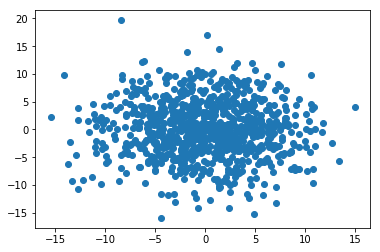

In [355]:
plt.scatter(train[:, 0], train[:, 1])
plt.show()

In [356]:
param = Param(P=train)

In [357]:
param.set_r1(n_near_neighbors=20)

Estimate r1
P: (900, 2)
sample 20 points, calculate near 20 neighbors.
estimate r1 = 2.0067651819119146


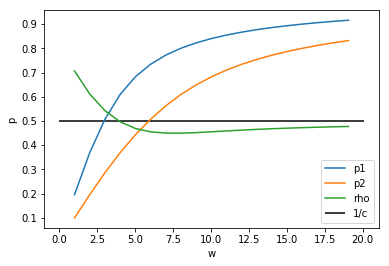

In [358]:
param.draw_W()

In [359]:
param.set_wkL(w=5, k=5, L=10)

set w = 5
p1 = 0.6814, p2 = 0.4415, rho = 0.4691
k = 5, L = 10


In [360]:
k, L, w = param.get_params()
(k, L, w)

(5, 10, 5)

In [361]:
%%time
hash_tables, G = construct_hash_tables(train, k, L, w, 1)

CPU times: user 770 ms, sys: 94.6 ms, total: 865 ms
Wall time: 763 ms


In [362]:
hash_table = hash_tables[0]

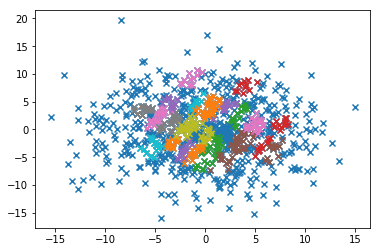

In [363]:
plt.scatter(train[:, 0], train[:, 1], marker='x')
for key, idxs in hash_table.items():
    if len(idxs) <= 10:
        continue
    plt.scatter(train[idxs, 0], train[idxs, 1], marker='x')
plt.show()

# Query Directed Probing Sequence

$$
x = (x_0, x_1, ..., x_i, ..., x_d) \\
f_i(q) = a_i\cdot q + b_i \\
h_i(q) = \lfloor \frac{a_i\cdot q + b_i}{W}\rfloor \\
x_i(-1) = f_i(q) - h_i(q) \times W \\
x_i(+1) = W - x_i(-1) \\
\text{score}(\Delta) = \sum_{i=1}^M x_i(\delta_i)^2
$$

## test steps

In [305]:
q = test[0]

In [256]:
g = G[0]
g

[(array([ 1.62434536, -0.61175641]), 0.0005718740867244332),
 (array([-0.80217284, -0.44887781]), 0.461692973843989),
 (array([-0.52817175, -1.07296862]), 1.9838373711533497),
 (array([-2.3634686 ,  1.13534535]), 3.4260975019837976),
 (array([ 0.3190391 , -0.24937038]), 0.13693796598963082)]

In [257]:
fq = np.array([q.dot(h[0]) + h[1] for h in g])
fq

array([ 12.92751432,  -6.55822217,  -3.2966654 , -15.17528793,
         2.56649604])

In [259]:
hq = np.floor(fq / w).astype(np.int)
hq

array([ 2, -2, -1, -4,  0])

In [157]:
w

5

In [155]:
fq / w

array([ 2.58550286, -1.31164443, -0.65933308, -3.03505759,  0.51329921])

In [152]:
x_minus = fq - hq * w
x_minus

array([2.92751432, 3.44177783, 1.7033346 , 4.82471207, 2.56649604])

In [153]:
x_plus = w - x_minus
x_plus

array([2.07248568, 1.55822217, 3.2966654 , 0.17528793, 2.43350396])

In [172]:
pi_1 = np.append(x_minus.reshape(-1, 1), np.repeat(-1, x_minus.shape[0]).reshape(-1, 1), axis=1)
pi_1 = np.append(pi_1, np.arange(pi_1.shape[0]).reshape(-1, 1), axis=1)
pi_1

array([[ 2.92751432, -1.        ,  0.        ],
       [ 3.44177783, -1.        ,  1.        ],
       [ 1.7033346 , -1.        ,  2.        ],
       [ 4.82471207, -1.        ,  3.        ],
       [ 2.56649604, -1.        ,  4.        ]])

In [173]:
pi_2 = np.append(x_plus.reshape(-1, 1), np.repeat(1, x_plus.shape[0]).reshape(-1, 1), axis=1)
pi_2 = np.append(pi_2, np.arange(pi_2.shape[0]).reshape(-1, 1), axis=1)

In [181]:
pi = np.append(pi_1, pi_2, axis=0)
pi

array([[ 2.92751432, -1.        ,  0.        ],
       [ 3.44177783, -1.        ,  1.        ],
       [ 1.7033346 , -1.        ,  2.        ],
       [ 4.82471207, -1.        ,  3.        ],
       [ 2.56649604, -1.        ,  4.        ],
       [ 2.07248568,  1.        ,  0.        ],
       [ 1.55822217,  1.        ,  1.        ],
       [ 3.2966654 ,  1.        ,  2.        ],
       [ 0.17528793,  1.        ,  3.        ],
       [ 2.43350396,  1.        ,  4.        ]])

**(score, operation, idx)**

In [182]:
pi = pi[pi[:, 0].argsort()]
pi

array([[ 0.17528793,  1.        ,  3.        ],
       [ 1.55822217,  1.        ,  1.        ],
       [ 1.7033346 , -1.        ,  2.        ],
       [ 2.07248568,  1.        ,  0.        ],
       [ 2.43350396,  1.        ,  4.        ],
       [ 2.56649604, -1.        ,  4.        ],
       [ 2.92751432, -1.        ,  0.        ],
       [ 3.2966654 ,  1.        ,  2.        ],
       [ 3.44177783, -1.        ,  1.        ],
       [ 4.82471207, -1.        ,  3.        ]])

## generate perturbation sets

In [183]:
import heapq

In [335]:
def array_to_tuple(a):
    return tuple(a.tolist())

def calc_score(A):
    s = 0
    for a in A:
        s += a[0]**2
    return s

In [412]:
def generate_T_perturbation_sets(pi, T, verbose=False):
    heap = []
    
    init = [0]
    
    heapq.heappush(heap, (calc_score(pi[init]), init))
    
    result = []
    for i in range(0, T):
        while True:
            score, Ai = heapq.heappop(heap)
            
            if verbose is True:
                print(Ai, score)
                
            shift_Ai = Ai[:]
            shift_Ai[-1] = Ai[-1] + 1
            
            if shift_Ai[-1] < len(pi): # bound
                heapq.heappush(heap, (calc_score(pi[shift_Ai]), shift_Ai))

            expand_Ai = Ai[:]
            expand_Ai.append(Ai[-1] + 1)
            
            if expand_Ai[-1] < len(pi): # bound
                heapq.heappush(heap, (calc_score(pi[expand_Ai]), expand_Ai))
            
            if len(np.unique(pi[Ai][:, 2])) == len(Ai): # for same idx, 
                                                        # +1 & -1 can't appear at the same time
                break
                
        result.append(Ai)

    return result

In [409]:
len(generate_T_perturbation_sets(pi, 100, verbose=True))

[0] 0.030725856898753644
[1] 2.4280563188707425
[0, 1] 2.458782175769496
[2] 2.901348743307529
[0, 2] 2.9320746002062825
[3] 4.295196908781689
[0, 3] 4.325922765680443
[1, 2] 5.329405062178271
[0, 1, 2] 5.360130919077025
[4] 5.921941499349836
[0, 4] 5.95266735624859
[5] 6.586901948632366
[0, 5] 6.61762780553112
[1, 3] 6.723253227652432
[0, 1, 3] 6.753979084551185
[2, 3] 7.196545652089218
[0, 2, 3] 7.227271508987972
[1, 4] 8.349997818220578
[0, 1, 4] 8.38072367511933
[6] 8.570340072649651
[0, 6] 8.601065929548405
[2, 4] 8.823290242657365
[0, 2, 4] 8.854016099556118
[1, 5] 9.014958267503108
[0, 1, 5] 9.045684124401863
[2, 5] 9.488250691939895
[0, 2, 5] 9.518976548838648
[1, 2, 3] 9.62460197095996
[0, 1, 2, 3] 9.655327827858713
[3, 4] 10.217138408131525
[0, 3, 4] 10.247864265030278
[7] 10.868002791006997
[3, 5] 10.882098857414054
[0, 7] 10.89872864790575
[0, 3, 5] 10.912824714312809
[1, 6] 10.998396391520394
[0, 1, 6] 11.029122248419148
[1, 2, 4] 11.251346561528106
[0, 1, 2, 4] 11.2820724

100

## multi probe query

In [419]:
def multi_probe_query(q, hash_tables, w, G, T, verbose=False):
    candidates = []
    
    for i, g in enumerate(G):
        fq = np.array([q.dot(h[0]) + h[1] for h in g])
        hq = np.floor(fq / w).astype(np.int)
        x_minus = fq - hq * w
        x_plus = w - x_minus
        
        pi_1 = np.append(x_minus.reshape(-1, 1), np.repeat(-1, x_minus.shape[0]).reshape(-1, 1), axis=1)
        pi_1 = np.append(pi_1, np.arange(pi_1.shape[0]).reshape(-1, 1), axis=1)
        
        pi_2 = np.append(x_plus.reshape(-1, 1), np.repeat(1, x_plus.shape[0]).reshape(-1, 1), axis=1)
        pi_2 = np.append(pi_2, np.arange(pi_2.shape[0]).reshape(-1, 1), axis=1)
        
        pi = np.append(pi_1, pi_2, axis=0)
        pi = pi[pi[:, 0].argsort()]

        if verbose is True:
            print(pi)
        
        
        if str(hq) in hash_tables[i]:
            candidates.append(hash_tables[i][str(hq)])
            
        perturbation_sets = generate_T_perturbation_sets(pi, T)
        
        for perturbation_set in perturbation_sets:
            temp = hq.copy()
            for m in perturbation_set:
                operation, idx = int(pi[m][1]), int(pi[m][2])
                temp[idx] += operation

            if (str(temp)) in hash_tables[i]:
                candidates.append(hash_tables[i][str(temp)])
        
    return np.array(candidates)

## test

In [420]:
q = test[0]

In [421]:
candidates = multi_probe_query(q, hash_tables, w, G, T=3, verbose=False)

In [422]:
np.unique(np.concatenate(candidates))

array([ 82, 104, 105, 118, 125, 142, 145, 183, 192, 197, 204, 207, 208,
       229, 232, 240, 241, 268, 273, 294, 299, 300, 315, 326, 336, 353,
       359, 362, 373, 387, 395, 398, 406, 421, 450, 455, 457, 463, 471,
       484, 509, 510, 513, 533, 535, 538, 542, 544, 545, 555, 569, 579,
       599, 605, 607, 621, 630, 639, 658, 661, 705, 714, 730, 734, 757,
       784, 803, 822, 827, 834, 869])